# Logistic Regression Modeling

In [ ]:
# import standard packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# import from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score,recall_score,precision_score, confusion_matrix

In [ ]:
# load needed data from the data folder
# could use kernel from another notebook but easier to load separately
# these files are _fe meaning they have had features added
full_data = pd.read_csv('data/cumulative_data_fe.csv')
train_data = pd.read_csv('data/train_data_fe.csv')
test_data = pd.read_csv('data/test_data_fe.csv')

In [ ]:
# confirm all dfs have the same number of features
print(full_data.shape)
print(train_data.shape)
print(test_data.shape)

(78612, 47)
(62890, 47)
(15722, 47)


In [ ]:
# reframe dataframes into X_test, X_train, y_test and y_train
# do not need to use train_test_split function because we had already separated into different dataframes for train and test
# remove id and img_id as these are not descriptive columns for prediction
y_train = train_data['stone_soil_enc']
y_test = test_data['stone_soil_enc']
X_train = train_data.drop(['stone_soil', 'stone_soil_enc', 'id', 'img_id'], axis=1)
X_test = test_data.drop(['stone_soil', 'stone_soil_enc', 'id', 'img_id'], axis=1)

In [ ]:
# columns to input into the variable selection code
print(X_train.columns)

Index(['da', 'dp', 'fwidth', 'flength', 'fthickness', 'elength', 'ethickness',
       'ewidth', 'volume', 'area', 'perimeter', 'chull_area',
       'chull_perimeter', 'sphericity', 'l_t_ratio', 't_l_aspect_ratio',
       'compactness', 'roundness', 'ellipse_ratio', 'circularity', 'solidity',
       'concavity', 'convexity', 'extent', 'hash', 'transparency', 'curvature',
       'surface_area', 'l_w_ratio', 'w_l_ratio', 'w_t_ratio', 't_w_ratio',
       'chull_surface_area', 'sieve', 'angularity', 'ellipticity',
       'fiber_length', 'fiber_width', 'krumbein_rnd', 'thick_vol_prod',
       'thick_perm_prod', 'thick_trans_prod', 'rnd_ell_prod'],
      dtype='object')


In [ ]:
## Recursive Feature Elimination to figure out which variables will be important towards predicting stone_soil_enc
## using logistic regression as the model to select features
log = LogisticRegression(max_iter = 400)
model_rfe = RFECV(log, cv = 5)
X = model_rfe.fit(X_train, y_train)
rfe = model_rfe.ranking_
features = ['da', 'dp', 'fwidth', 'flength', 'fthickness',
       'elength', 'ethickness', 'ewidth', 'volume', 'area', 'perimeter',
       'chull_area', 'chull_perimeter', 'sphericity', 'l_t_ratio',
       't_l_aspect_ratio', 'compactness', 'roundness', 'ellipse_ratio',
       'circularity', 'solidity', 'concavity', 'convexity', 'extent', 'hash',
       'transparency', 'curvature', 'surface_area', 'l_w_ratio', 'w_l_ratio',
       'w_t_ratio', 't_w_ratio', 'chull_surface_area', 'sieve', 'angularity',
       'ellipticity', 'fiber_length', 'fiber_width', 'krumbein_rnd',
       'thick_vol_prod', 'thick_perm_prod', 'thick_trans_prod',
       'rnd_ell_prod']
rfe_df = pd.DataFrame({'features': features, 'rfe_rank': rfe}, index = np.arange(len(features)))

In [ ]:
## Selecting the features that matter
new_rfe = rfe_df[rfe_df["rfe_rank"] == 1]

In [ ]:
# viewing the selected features
new_rfe

,features,rfe_rank
15,t_l_aspect_ratio,1
17,roundness,1
18,ellipse_ratio,1
19,circularity,1
20,solidity,1
21,concavity,1
25,transparency,1
26,curvature,1
28,l_w_ratio,1
30,w_t_ratio,1


In [ ]:
# save only selected features in new dataframes with the rows from x train and x test to use for model
l = []
for col in new_rfe["features"]:
    l.append(col)
X_train_new = X_train[l]
X_test_new = X_test[l]

In [ ]:
# 16 important features
# same amount of rows as original
X_train_new.shape

(62890, 16)

### Create model

In [ ]:
# fit the model using logistic regression
# using max_iter 400 to avoid error message
# using X_train_new to select only the 16 features that were selected
log = LogisticRegression(max_iter = 400)
log.fit(X_train_new, y_train)

LogisticRegression(max_iter=400)

### Cross validation

In [ ]:
# cross validation using f1
# low f1 score indicates low precision and low recall
score = cross_val_score(log, X_train_new, y_train, scoring = "f1")
print(score)
print(score.mean())

[0.52733119 0.49638554 0.49156627 0.49392713 0.50203749]
0.5022495224516301


### Test Performance

In [ ]:
# test the performance of the model by calculating some metrics on test data
# accuracy metric is high but precision, recall and f1 score are on the lower end
y_pred = log.predict(X_test_new)
acc = accuracy_score(y_test,y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test,y_pred)
results = pd.DataFrame([['Logistic Regression', acc,prec,rec,f1]],columns=['Model', 'Accuracy', 'Precision', 'Recall','F1 Score'])
results

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.945999,0.802564,0.288479,0.424407


Test Data Accuracy: 0.9460


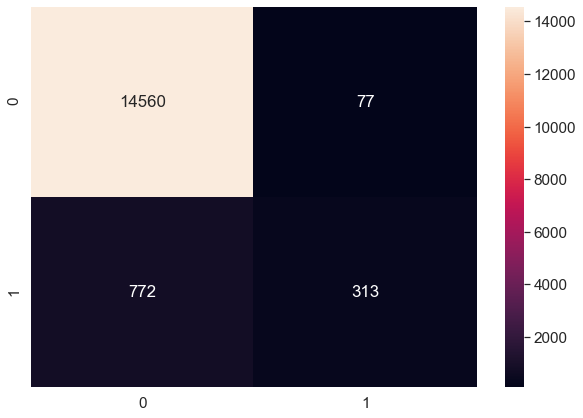

In [ ]:
# Confusion Matrix creation
cm = confusion_matrix(y_test, y_pred) # rows = truth, cols = prediction
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, fmt='g')
print("Test Data Accuracy: %0.4f" % accuracy_score(y_test, y_pred)) 

### Change Parameters of Model
#### Trying to increase the metrics of the model

In [ ]:
# change parameters of the log regression to try to increase f1 score
# start with penalty
# tried a variety of different combinations of parameters and 
# this was the one with the highest cross validation f1 score for the train data
# same selected features as the original model
# use log_3 to differentiate model
log_2 = LogisticRegression(max_iter = 600, penalty="l1", tol=0.001, solver="saga")
log_2.fit(X_train_new, y_train)

LogisticRegression(max_iter=600, penalty='l1', solver='saga', tol=0.001)

In [ ]:
# cross validation using f1
# f1 is slightly higher than original model on cross validation
score = cross_val_score(log_2, X_train_new, y_train, scoring = "f1")
print(score)
print(score.mean())

[0.56702619 0.53488372 0.52550232 0.51612903 0.52664577]
0.534037406750159


In [ ]:
# test the performance of the model by calculating some metrics
# on new data, performs worse than original model for all metrics
y_pred = log_2.predict(X_test_new)
acc = accuracy_score(y_test,y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test,y_pred)
results = pd.DataFrame([['Logistic Regression', acc,prec,rec,f1]],columns=['Model', 'Accuracy', 'Precision', 'Recall','F1 Score'])
results

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.945236,0.82,0.264516,0.4


In [ ]:
# also try using different features and see if that increases the model metrics
# Recursive Feature Elimination via Lasso Regression to figure out which variables will be important 
# instead of the log regression that we used initially
model_rfe = RFECV(Lasso(alpha = 0.0001), cv = 5)
x = model_rfe.fit(X_train, y_train)
rfe = model_rfe.ranking_
features = ['da', 'dp', 'fwidth', 'flength', 'fthickness',
       'elength', 'ethickness', 'ewidth', 'volume', 'area', 'perimeter',
       'chull_area', 'chull_perimeter', 'sphericity', 'l_t_ratio',
       't_l_aspect_ratio', 'compactness', 'roundness', 'ellipse_ratio',
       'circularity', 'solidity', 'concavity', 'convexity', 'extent', 'hash',
       'transparency', 'curvature', 'surface_area', 'l_w_ratio', 'w_l_ratio',
       'w_t_ratio', 't_w_ratio', 'chull_surface_area', 'sieve', 'angularity',
       'ellipticity', 'fiber_length', 'fiber_width', 'krumbein_rnd',
       'thick_vol_prod', 'thick_perm_prod', 'thick_trans_prod',
       'rnd_ell_prod']
rfe_df_2 = pd.DataFrame({'features': features, 'rfe_rank': rfe}, index = np.arange(len(features)))

In [ ]:
## Selecting the features that matter
# different features than using log
new_rfe_2 = rfe_df_2[rfe_df_2["rfe_rank"] == 1]
new_rfe_2

,features,rfe_rank
0,da,1
18,ellipse_ratio,1
19,circularity,1
20,solidity,1
25,transparency,1
26,curvature,1
29,w_l_ratio,1
30,w_t_ratio,1
31,t_w_ratio,1
34,angularity,1


In [ ]:
# save only selected features in new dataframes with the rows from x train and x test to use for model
m = []
for col in new_rfe_2["features"]:
    m.append(col)
X_train_new_2 = X_train[m]
X_test_new_2 = X_test[m]

In [ ]:
# 13 instead of 16 selected features
X_train_new_2.shape

(62890, 13)

In [ ]:
# refit model with new features
# use log_3 to differentiate model
log_3 = LogisticRegression(max_iter = 600, penalty="l1", tol=0.001, solver="saga")
log_3.fit(X_train_new_2, y_train)

LogisticRegression(max_iter=600, penalty='l1', solver='saga', tol=0.001)

In [ ]:
# cross validation using f1
# f1 is higher than original model
score = cross_val_score(log_3, X_train_new_2, y_train, scoring = "f1")
print(score)
print(score.mean())

[0.55752896 0.529274   0.52281516 0.50826121 0.5318818 ]
0.5299522272893471


In [ ]:
# test the performance of the model by calculating some metrics
# on new data, performs worse than original model for all metrics
y_pred = log_3.predict(X_test_new_2)
acc = accuracy_score(y_test,y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test,y_pred)
results = pd.DataFrame([['Logistic Regression', acc,prec,rec,f1]],columns=['Model', 'Accuracy', 'Precision', 'Recall','F1 Score'])
results

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.9439,0.820189,0.239631,0.370899


In [ ]:
# conclude that the original model "log" is the best model using logistic regression when testing on new data